In [1]:
from lib.utility import retrieve_county_data


ModuleNotFoundError: No module named 'requests'

In [2]:
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import numpy as np
import folium
import contextily as cx
#import pysal as ps
#from pysal.contrib.viz import mapping as maps

In [3]:
#url = "https://maps.stlouisco.com/arcgis/rest/services/OpenData/OpenData/FeatureServer/7/query?where=PROPCLASS%20%3D%20'R'&outFields=*&geometry=-90.458%2C38.722%2C-90.384%2C38.746&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelContains&outSR=4326&f=json"
url = "https://maps.stlouisco.com/arcgis/rest/services/OpenData/OpenData/FeatureServer/7/query?where=1%3D1&outFields=*&geometry=-90.454%2C38.723%2C-90.381%2C38.746&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=4326&f=json"
url_small = "https://maps.stlouisco.com/arcgis/rest/services/OpenData/OpenData/FeatureServer/7/query?where=1%3D1&outFields=*&geometry=-90.412%2C38.728%2C-90.403%2C38.731&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelContains&returnGeometry=false&outSR=4326&f=json"
url_small_geom = "https://maps.stlouisco.com/arcgis/rest/services/OpenData/OpenData/FeatureServer/7/query?where=1%3D1&outFields=*&geometry=-90.412%2C38.728%2C-90.403%2C38.731&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelContains&outSR=4326&f=json"

In [4]:
# Refresh data:
if True:
    retrieve_county_data(url, "./data/parcels/stl_county_test_set.csv")

# API data
df = pd.read_csv("./data/parcels/stl_county_test_set.csv", index_col='index')
df["geometry"] = df["geometry"].apply(wkt.loads)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [5]:
df.head()
#df.columns

,OBJECTID,PARENT_LOC,LOCATOR,TAXYR,OWNER_NAME,PROP_ADRNUM,PROP_ADD,PROP_ZIP,OWN_ADD,OWN_CITY,...,MUNI_ZONING,TRASH_DISTRICT,TRASH_OPTOUT,COGIS,CODE_ENFORCEMENT_DISTRICT,PMZ_NEIGHBORHOOD,geometry.rings,geometry,area,owner_cat
index,,,,,,,,,,,,,,,,,,,,,
0,85257,12N640314,12N640314,2022,J P HOMSHER SDI L L C,11704,11704 ST CHARLES ROCK RD,63044,532 FOX RIDGE RD,SAINT LOUIS,...,NaN,NaN,NaN,2313,5,20020,"[[[-90.41439525890395, 38.74420833044413], [-9...",POLYGON ((-90.41439525890395 38.74420833044413...,954.054897,llc
1,85259,12N640350,12N640350,2022,J P HOMSHER SDI LLC,11700,11700 ST CHARLES ROCK RD A,63044,532 FOX RIDGE RD,SAINT LOUIS,...,NaN,NaN,NaN,2313,5,20020,"[[[-90.41413720536359, 38.744333389815665], [-...",POLYGON ((-90.41413720536359 38.74433338981566...,371.722958,llc
2,85260,12L430164,12L430164,2022,ST LOUIS CITY OF,11212,11212 HUNTER DR A,63044,PO BOX 10212,SAINT LOUIS,...,NaN,NaN,NaN,1501,5,20044,"[[[-90.38537750579444, 38.74424108496569], [-9...",POLYGON ((-90.38537750579444 38.74424108496569...,5802.784943,other
3,85261,12M530373,12M530373,2022,BRIDGETON CITY OF,4056,4056 FEE FEE RD,63044,4056 FEE FEE RD,BRIDGETON,...,NaN,NaN,NaN,2311,5,20018,"[[[-90.399836647074, 38.74450051154892], [-90....","POLYGON ((-90.399836647074 38.74450051154892, ...",241.391278,owner_occupy
4,85263,12N640323,12N640323,2022,J P HOMSHER SDI LLC,11700,11700 ST CHARLES ROCK RD,63044,532 FOX RIDGE RD,SAINT LOUIS,...,NaN,NaN,NaN,2313,5,20020,"[[[-90.41439917173378, 38.74442367932754], [-9...",POLYGON ((-90.41439917173378 38.74442367932754...,1311.139583,llc


In [6]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry="geometry")

In [7]:
grouped = df.groupby(["owner_cat"])
df_stats = pd.DataFrame(columns=['owner_type', 'mean_instances', 'mean_area'])
for name, group in grouped:
    owners = group.groupby(["OWNER_NAME"])
    df_stats.loc[len(df_stats.index)] = [name, 
                                         owners.count()["OBJECTID"].mean(),
                                         group["area"].mean()]

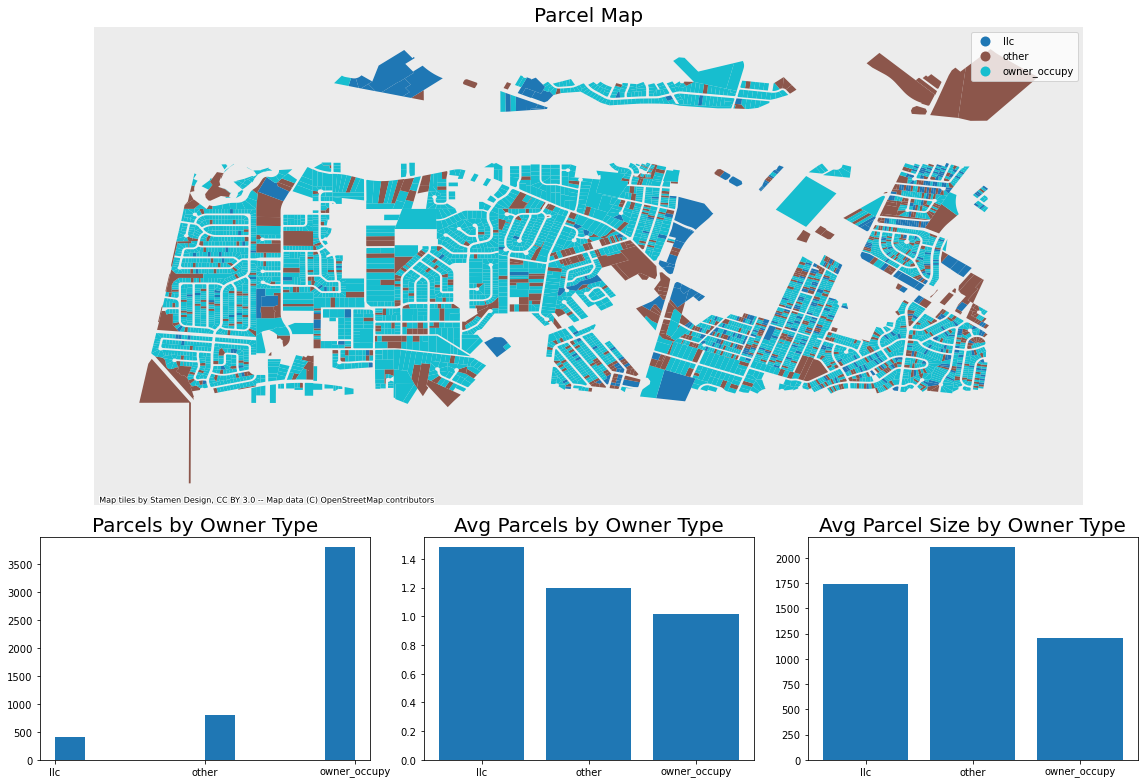

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,11), tight_layout=True)

# create merged first row
gs = axs[0, 0].get_gridspec()
for ax in axs[0:2,0:]:
    for a in ax:
        a.remove()
axbig = fig.add_subplot(gs[0:2, 0:])

gdf.plot(ax=axbig, 
         column=gdf['owner_cat'], 
         legend=True, 
         categorical=True)
cx.add_basemap(axbig, source=cx.providers.Stamen.TonerLite, zoom=20, alpha=0.5)
cx.add_basemap(axbig, source=cx.providers.Stamen.TonerLabels, zoom=20, alpha=0.5)
axbig.set_axis_off()
axbig.title.set_text('Parcel Map')
axbig.title.set_fontsize(20)

axs[2][0].hist(df['owner_cat'])
axs[2][0].title.set_text('Parcels by Owner Type')
axs[2][0].title.set_fontsize(20)

axs[2][1].bar(x=df_stats['owner_type'], height=df_stats['mean_instances'])
axs[2][1].title.set_text('Avg Parcels by Owner Type')
axs[2][1].title.set_fontsize(20)

axs[2][2].bar(x=df_stats['owner_type'], height=df_stats['mean_area'])
axs[2][2].title.set_text('Avg Parcel Size by Owner Type')
axs[2][2].title.set_fontsize(20)

plt.show()

In [9]:
# TODO:
# Match owner with address
# Gather list of owner fetures for catagorization
# Incorporate spark?
# Add metered data retrieval
# Visuals:
#    - Color Coded map
#    - Reactive map?
#    - Bar chart for owner type by instance count
#    - Bar chart for owner type by area
#    - Compare metrics from different categorization methods

In [10]:
# Add color feature based on owner category:
#gdf["color"] = np.select(
#    condlist=[gdf['owner_cat'] == 'owner_occupy', gdf['owner_cat'] == 'llc', gdf['owner_cat'] == 'other'],
#    choicelist=['red', 'green', 'grey'],
#    default='black')